In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import skimage
import scipy
%matplotlib inline

import harris

from sklearn import linear_model

In [2]:
def read_image(IMG_NAME):
    img = cv2.imread(IMG_NAME)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [72]:
# def ops(IMG_NAME, plot=True):
#     s1 = read_image(IMG_NAME)
def ops(s1, plot=True, erode_size=5, dilate_size=3, plot_sift=True):
    if plot:
        plt.imshow(s1, cmap = "gray")
        plt.show()
    
    kernel = np.ones((erode_size,erode_size),np.uint8)
    erosion = cv2.erode(s1,kernel,iterations = 20)
    if plot:
        plt.imshow(erosion, cmap = "gray")
        plt.show()
    
    kernel = np.ones((dilate_size,dilate_size),np.uint8)
    dilation = cv2.dilate(erosion,kernel,iterations = 20)
    if plot:
        plt.imshow(dilation, cmap = "gray")
        plt.show()
    
    (thresh, im_bw) = cv2.threshold(dilation, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    if plot:
        plt.imshow(im_bw, cmap = "gray")
        plt.show()
    
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(im_bw,None)
    keypoints = np.array([p.pt for p in kp]).astype(int)
#     print(keypoints.shape)
    keypoints_map = np.zeros(s1.shape)
    keypoints_map[keypoints[:, 1], keypoints[:, 0]] = 1
    if plot or plot_sift:
#         plt.imshow(keypoints_map, cmap = "gray")
#         plt.show()
        harris.plot_harris_points(im_bw, np.flip(keypoints, 1))
    return im_bw, keypoints, keypoints_map

In [ ]:
# # #prewitt
# prewitx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
# prewity = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
# temp = np.zeros(s1plot.shape).astype('int')
# # print(type(temp[0,0,0]))
# # print(type(s1plot[0,0,0]))
# for i in range(3):
#     temp[:, :, i] = cv2.filter2D(s1plot[:, :, i], -1, prewitx)
# plt.imshow(temp)
# plt.show()
# plt.imshow((s1plot-temp).astype('int'))
# plt.show()

In [4]:
def best_linear_boundary_detection(IMG_NAME):
    s1plot = cv2.imread(IMG_NAME)
    if s1plot.shape[0] > 800:
        s1plot = cv2.resize(s1plot, (800, 1000))
    s1 = cv2.cvtColor(s1plot, cv2.COLOR_BGR2GRAY)
    div =  int(s1.shape[1]/2)

    coef = 1.0
    coef_threshold = -0.3
    left = s1[:, :div]
    while coef >= coef_threshold:
        _, kpt, _ = ops(left, plot=False, erode_size=3, dilate_size=3, plot_sift=False)
        ransacl = linear_model.RANSACRegressor(linear_model.LinearRegression(), residual_threshold = 10)
        ransacl = ransacl.fit(kpt[:, 0].reshape(-1, 1), kpt[:, 1].reshape(-1, 1))
    #     print(ransacl.estimator_.coef_, ransacl.estimator_.intercept_)
        coef = ransacl.estimator_.coef_[0,0]
#         print(coef)
        if coef >= coef_threshold:
            inliers_mask = ransacl.inlier_mask_.reshape(-1, 1)
            inliers_idx =  np.argwhere(inliers_mask==True)
            kpt = np.delete(kpt, inliers_idx, 0)
#             print(kpt.shape)
#     x = np.linspace(0, left.shape[1], 1000).reshape(1, -1)
#     plt.plot(x, x * ransacl.estimator_.coef_ + ransacl.estimator_.intercept_, 'b.')
#     plt.imshow(s1plot[:, :div])
#     plt.show()

    coef = -1.0
    coef_threshold = 0.3
    right = s1[:, div:]
    while coef <= coef_threshold:
        _, kpt, _ = ops(right, plot=False, erode_size=3, dilate_size=3, plot_sift=False)
        ransacr = linear_model.RANSACRegressor(linear_model.LinearRegression())
        ransacr = ransacr.fit(kpt[:, 0].reshape(-1, 1), kpt[:, 1].reshape(-1, 1))
    #     print(ransacr.estimator_.coef_, ransacr.estimator_.intercept_)
        coef = ransacr.estimator_.coef_[0,0]
#         print(coef)
        if coef <= coef_threshold:
            inliers_mask = ransacr.inlier_mask_.reshape(-1, 1)
            inliers_idx =  np.argwhere(inliers_mask==True)
            kpt = np.delete(kpt, inliers_idx, 0)
#             print(kpt.shape)
    # plt.plot(kpt[:, 0].reshape(1, -1), kpt[:, 0] * ransac.estimator_.coef_ + ransac.estimator_.intercept_, 'b.')
    
#     plt.plot(x, x * ransacr.estimator_.coef_ + ransacr.estimator_.intercept_, 'b.')
#     plt.imshow(s1plot[:, div:])
#     plt.show()

    x = np.linspace(0, s1plot.shape[1], 1000).reshape(1, -1)
#     print(ransacl.estimator_.coef_, ransacl.estimator_.intercept_)
#     print(ransacr.estimator_.coef_, ransacr.estimator_.intercept_)
    plt.plot(x, x * ransacl.estimator_.coef_ + ransacl.estimator_.intercept_, 'b.')
    plt.plot(x, (x-div) * ransacr.estimator_.coef_ + ransacr.estimator_.intercept_ , 'b.')
    plt.imshow(s1plot)
    plt.show()

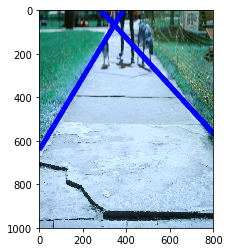

In [158]:
best_linear_boundary_detection("sidewalk/4.jpg")

best_linear_boundary_detection runs ransac and throw away keypoints from poor estimation 
=> runtime depends on the random selected points and thus varies from time to time  
e.g. thick crack at the bottom of this image generates many sift points for line fitting  
=> high possibility of fitting this crack over the actual sidewalk boundary

In [21]:
def best_linear_boundary_detection(isName, IMG_NAME="", s1plot=None, plot=False, plot_sift=False):
    if isName:
        s1plot = cv2.imread(IMG_NAME)
        print("read_images")
    if s1plot.shape[0] > 800 or s1plot.shape[1] > 800:
        s1plot = cv2.resize(s1plot, (1000, 800))
    s1 = cv2.cvtColor(s1plot, cv2.COLOR_BGR2GRAY)
    div =  int(s1.shape[1]/2)

    coef = 1.0
    coef_threshold = -0.3
    left = s1[:, :div]
    while coef >= coef_threshold:
        _, kpt, _ = ops(left, plot=plot, erode_size=3, dilate_size=3, plot_sift=plot_sift)
        ransacl = linear_model.RANSACRegressor(linear_model.LinearRegression(), residual_threshold = 10)
        ransacl = ransacl.fit(kpt[:, 0].reshape(-1, 1), kpt[:, 1].reshape(-1, 1))
    #     print(ransacl.estimator_.coef_, ransacl.estimator_.intercept_)
        coef = ransacl.estimator_.coef_[0,0]
#         print(coef)
        if coef >= coef_threshold:
            inliers_mask = ransacl.inlier_mask_.reshape(-1, 1)
            inliers_idx =  np.argwhere(inliers_mask==True)
            kpt = np.delete(kpt, inliers_idx, 0)
#             print(kpt.shape)
    if plot or plot_sift:
        x = np.linspace(0, left.shape[1], 1000).reshape(1, -1)
        plt.plot(x, x * ransacl.estimator_.coef_ + ransacl.estimator_.intercept_, 'b.')
        plt.imshow(s1plot[:, :div])
        plt.show()

    coef = -1.0
    coef_threshold = 0.3
    right = s1[:, div:]
    while coef <= coef_threshold:
        _, kpt, _ = ops(right, plot=plot, erode_size=3, dilate_size=3, plot_sift=plot_sift)
        ransacr = linear_model.RANSACRegressor(linear_model.LinearRegression())
        ransacr = ransacr.fit(kpt[:, 0].reshape(-1, 1), kpt[:, 1].reshape(-1, 1))
    #     print(ransacr.estimator_.coef_, ransacr.estimator_.intercept_)
        coef = ransacr.estimator_.coef_[0,0]
#         print(coef)
        if coef <= coef_threshold:
            inliers_mask = ransacr.inlier_mask_.reshape(-1, 1)
            inliers_idx =  np.argwhere(inliers_mask==True)
            kpt = np.delete(kpt, inliers_idx, 0)
#             print(kpt.shape)
    # plt.plot(kpt[:, 0].reshape(1, -1), kpt[:, 0] * ransac.estimator_.coef_ + ransac.estimator_.intercept_, 'b.')
    if plot or plot_sift:
        plt.plot(x, x * ransacr.estimator_.coef_ + ransacr.estimator_.intercept_, 'b.')
        plt.imshow(s1plot[:, div:])
        plt.show()

    x = np.linspace(0, s1plot.shape[1], 1000).reshape(1, -1)
#     print(ransacl.estimator_.coef_, ransacl.estimator_.intercept_)
#     print(ransacr.estimator_.coef_, ransacr.estimator_.intercept_)
    plt.plot(x, x * ransacl.estimator_.coef_ + ransacl.estimator_.intercept_, 'b.')
    plt.plot(x, (x-div) * ransacr.estimator_.coef_ + ransacr.estimator_.intercept_ , 'b.')
    plt.imshow(s1plot)
    plt.show()
    return s1plot

read_images


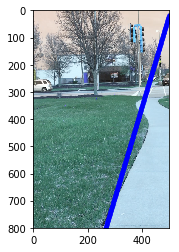

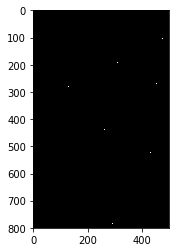

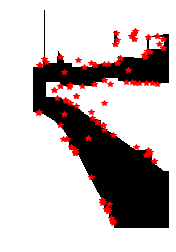

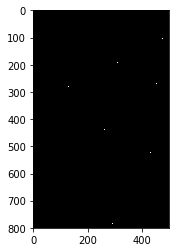

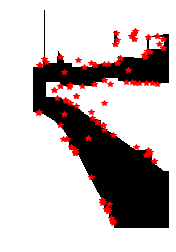

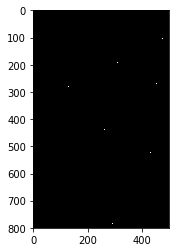

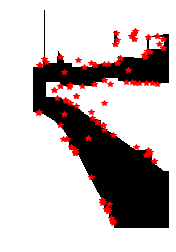

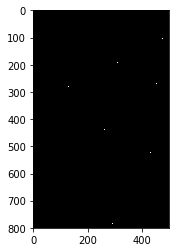

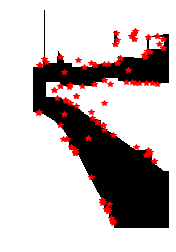

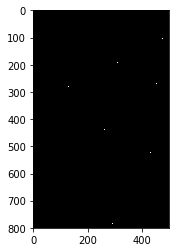

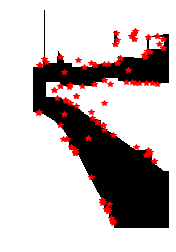

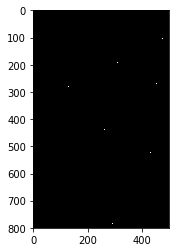

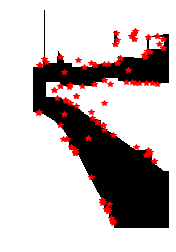

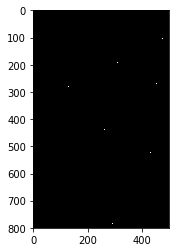

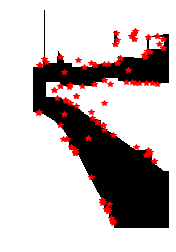

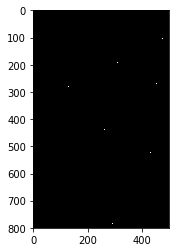

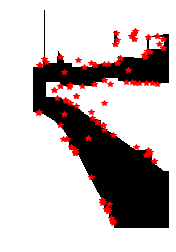

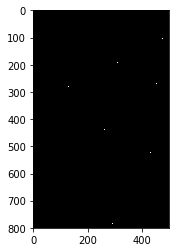

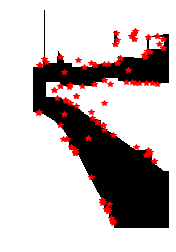

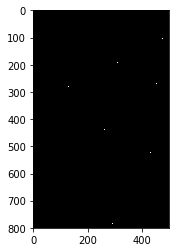

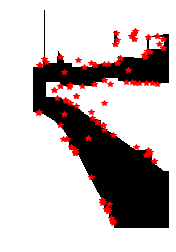

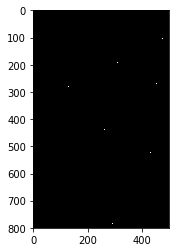

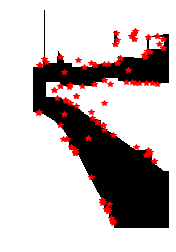

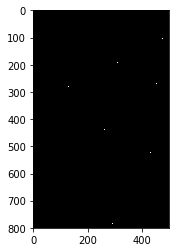

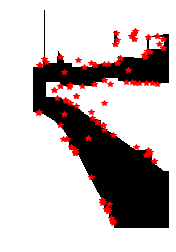

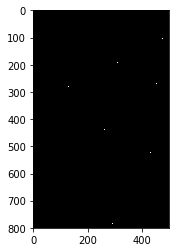

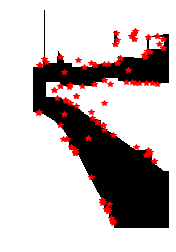

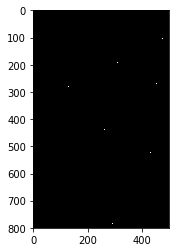

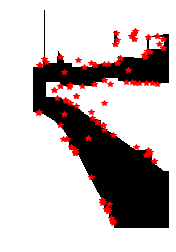

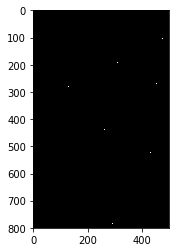

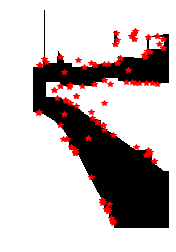

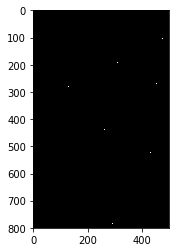

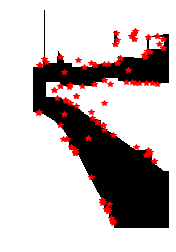

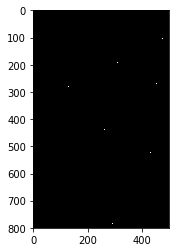

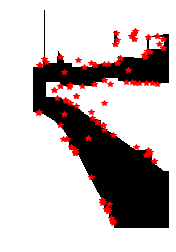

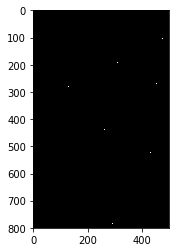

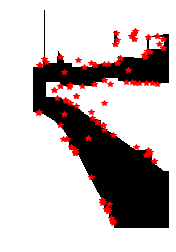

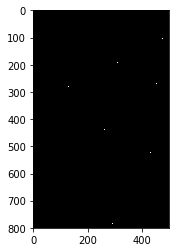

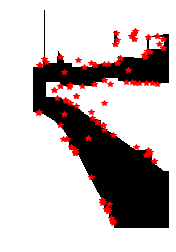

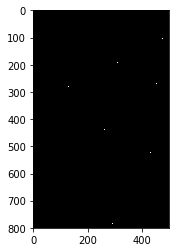

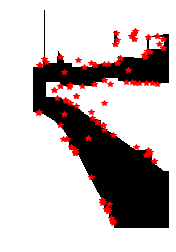

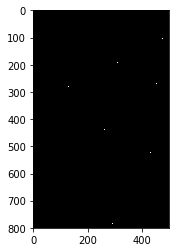

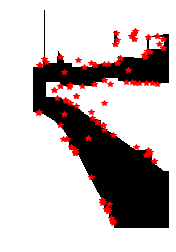

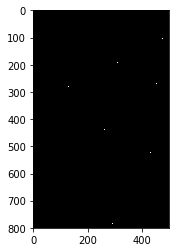

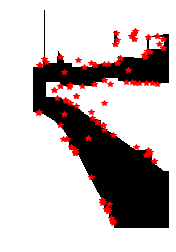

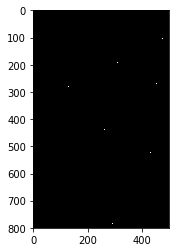

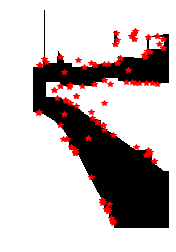

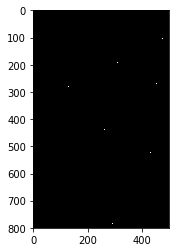

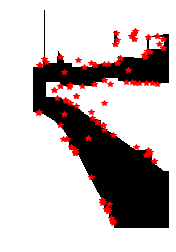

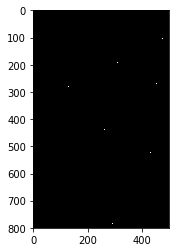

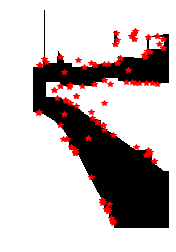

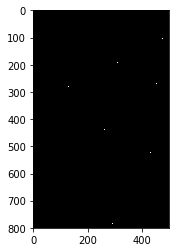

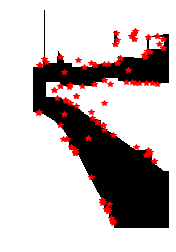

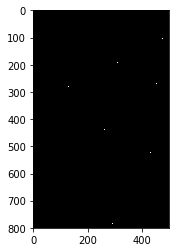

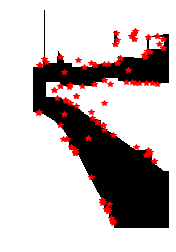

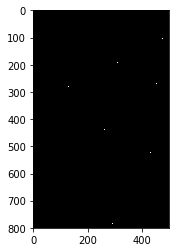

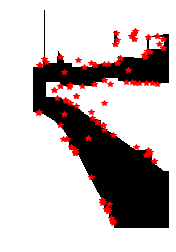

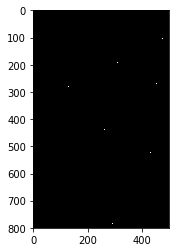

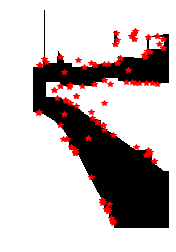

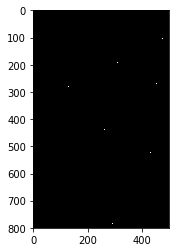

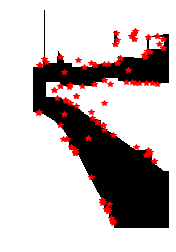

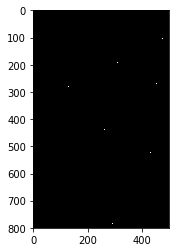

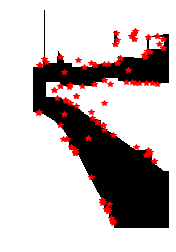

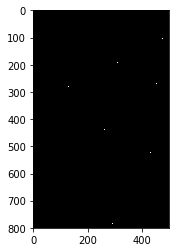

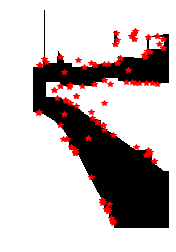

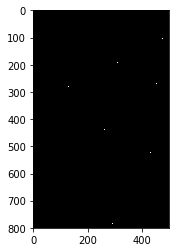

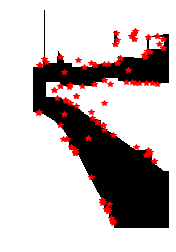

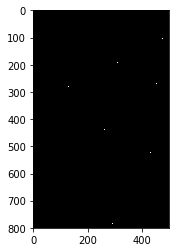

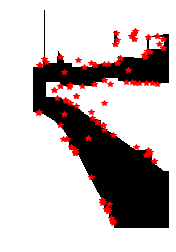

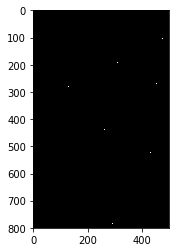

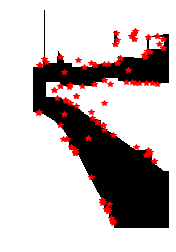

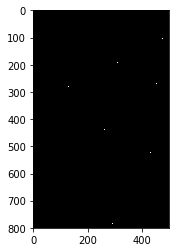

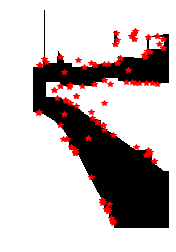

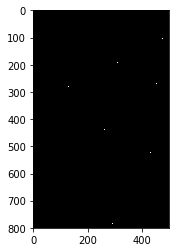

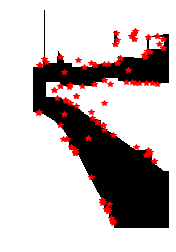

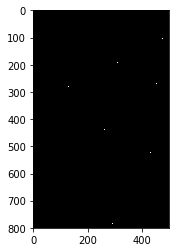

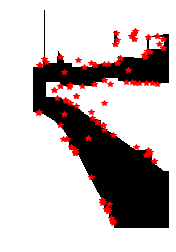

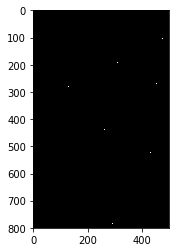

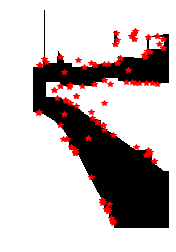

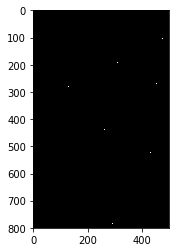

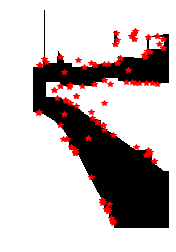

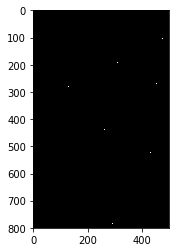

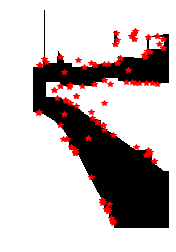

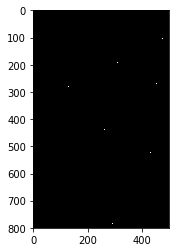

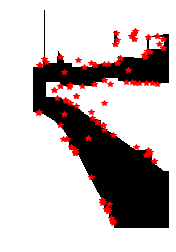

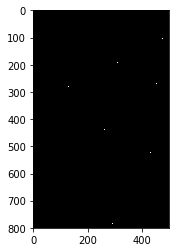

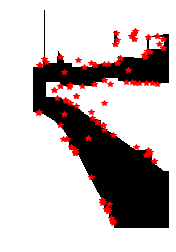

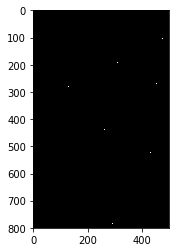

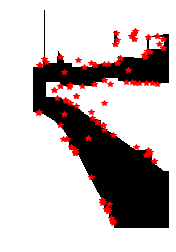

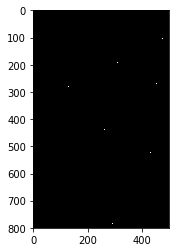

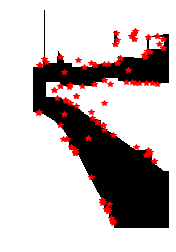

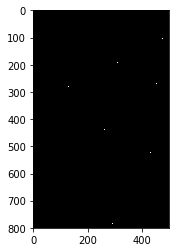

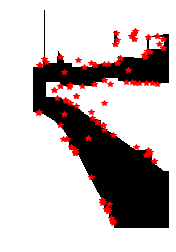

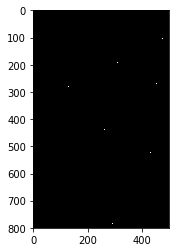

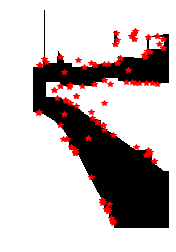

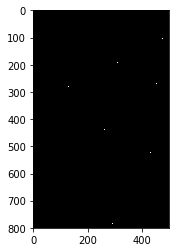

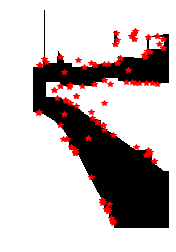

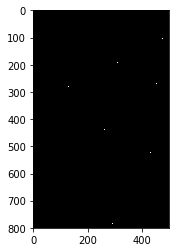

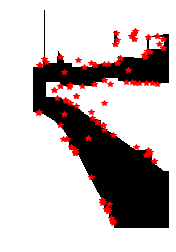

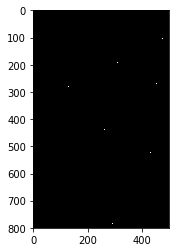

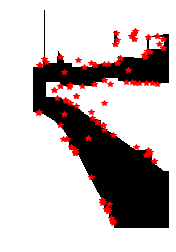

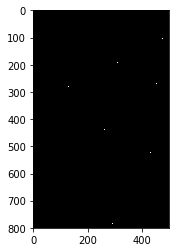

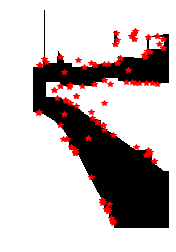

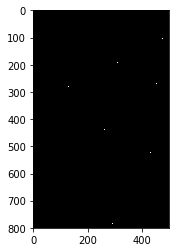

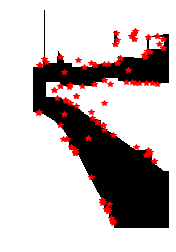

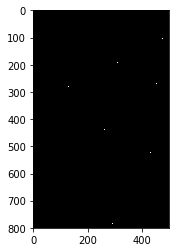

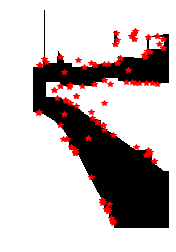

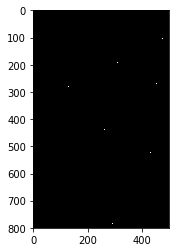

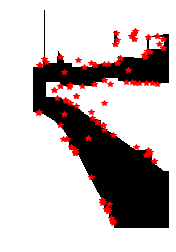

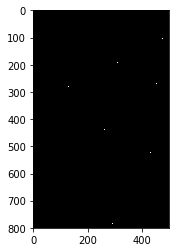

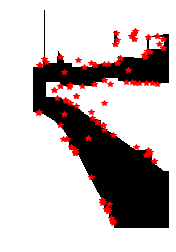

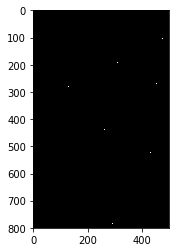

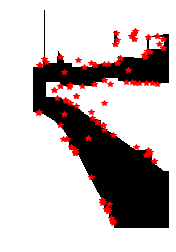

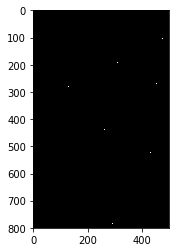

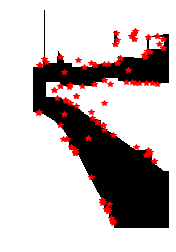

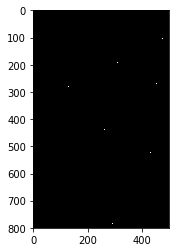

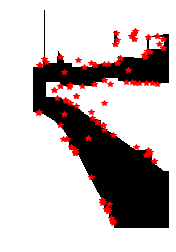

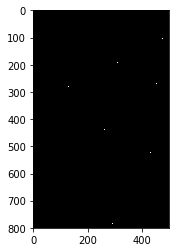

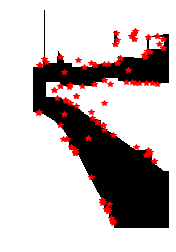

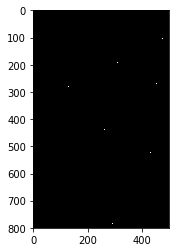

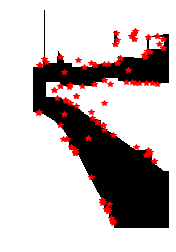

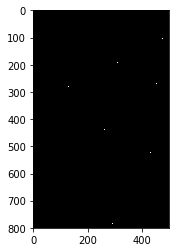

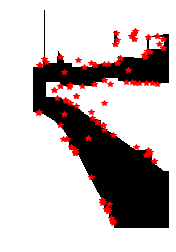

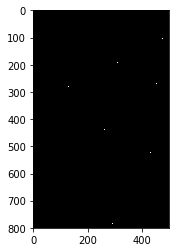

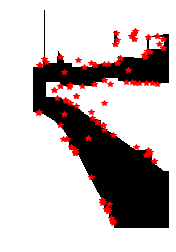

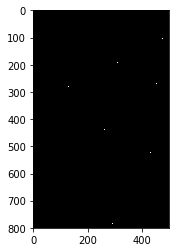

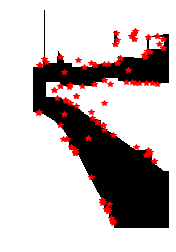

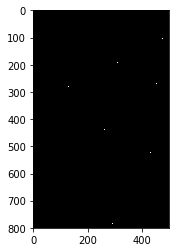

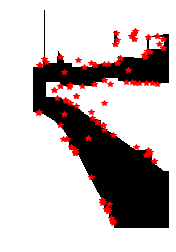

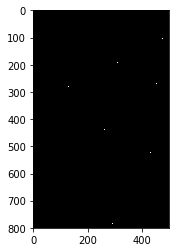

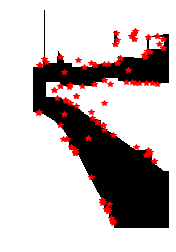

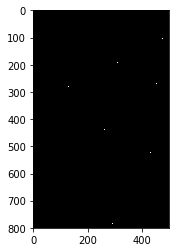

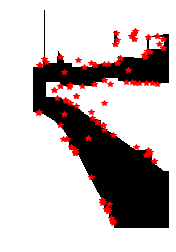

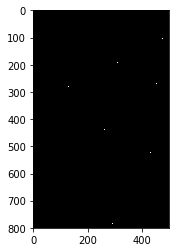

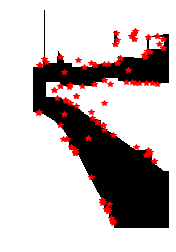

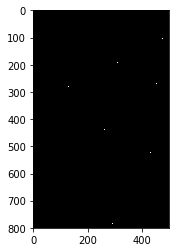

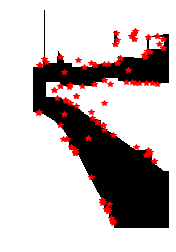

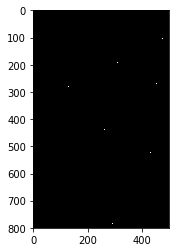

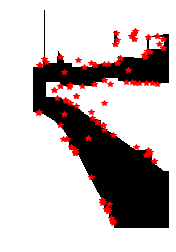

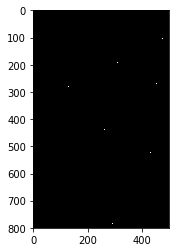

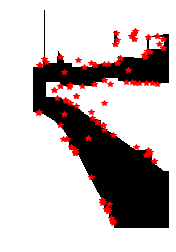

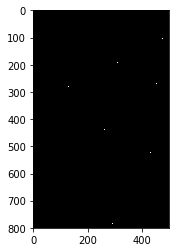

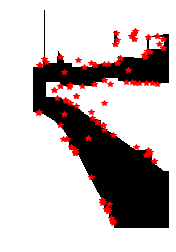

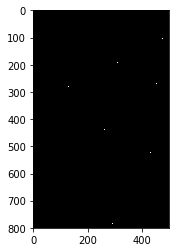

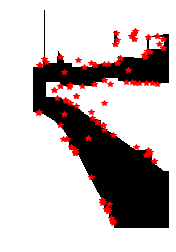

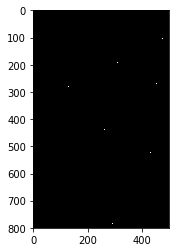

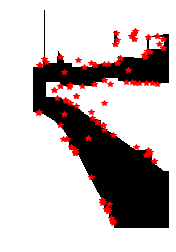

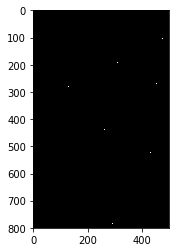

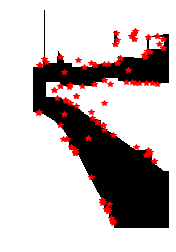

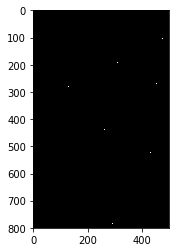

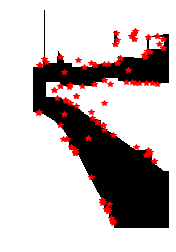

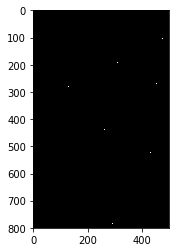

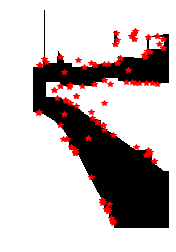

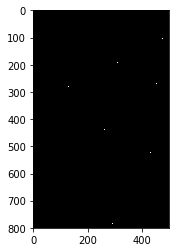

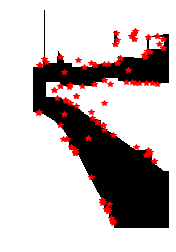

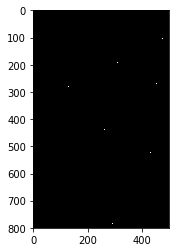

KeyboardInterrupt: 

In [20]:
best_linear_boundary_detection(True, IMG_NAME="/Users/yxiao/Desktop/1.png", plot=False, plot_sift=True)

read_images


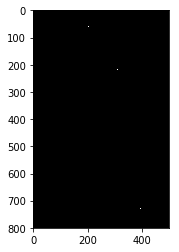

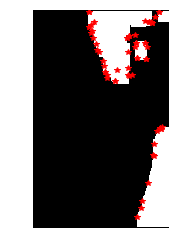

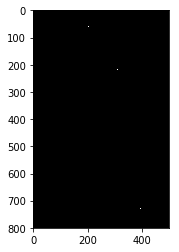

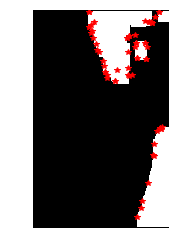

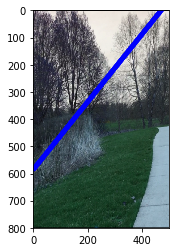

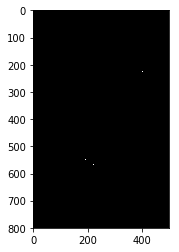

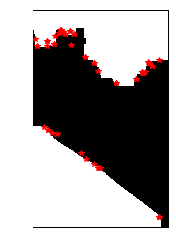

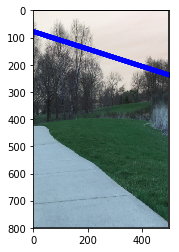

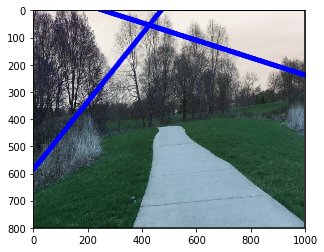

array([[[11, 10, 10],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [43, 40, 39],
        [53, 50, 48],
        [53, 50, 48]],

       [[10, 10, 10],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [43, 40, 39],
        [52, 49, 47],
        [53, 49, 48]],

       [[21, 20, 21],
        [11, 10, 11],
        [11, 11, 12],
        ...,
        [43, 40, 39],
        [52, 49, 48],
        [54, 50, 49]],

       ...,

       [[24, 52, 36],
        [ 9, 39, 21],
        [ 9, 37, 20],
        ...,
        [42, 40, 38],
        [52, 49, 47],
        [53, 49, 48]],

       [[16, 28, 21],
        [ 4, 16,  8],
        [ 4, 15,  8],
        ...,
        [42, 39, 38],
        [51, 48, 46],
        [52, 49, 48]],

       [[11, 11, 11],
        [ 0,  1,  0],
        [ 0,  1,  0],
        ...,
        [42, 40, 39],
        [52, 49, 47],
        [53, 49, 48]]], dtype=uint8)

In [23]:
best_linear_boundary_detection(True, IMG_NAME="/Users/yxiao/Desktop/2.png", plot=False, plot_sift=True)

# ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ best_linear_boundary_detection   ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
works on pic 1-4   
  
  
    
    

# </br>
# </br>
# </br>
# </br>
# </br>
# ↓↓↓↓↓↓↓↓↓best_linear_boundary_detection_with_ROI ↓↓↓↓↓↓↓↓↓ 

In [65]:
def ROI(img):
    h,w = img.shape[0],img.shape[1]
#     poly = np.array([[(0,h),(w,h),(int(3*w/4), int(h/3)), (int(w/4), int(h/3))]])
    poly = np.array([[(0,h),(w,h),(int(w/2), int(h/4))]])
#     print(poly)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask,poly,255)
    #show_image_gray(mask)
    masked_image = cv2.bitwise_and(img,mask)
    return masked_image

In [87]:
def best_linear_boundary_detection_with_ROI(isName, IMG_NAME="", s1plot=None, plot=False, plot_sift=False):
    if isName:
        s1plot = cv2.imread(IMG_NAME)
#         print("read_images")
    if s1plot.shape[0] > 800 or s1plot.shape[1] > 800:
        s1plot = cv2.resize(s1plot, (1000, 800))
    s1 = cv2.cvtColor(s1plot, cv2.COLOR_BGR2GRAY)
    s1 = ROI(s1)
    div =  int(s1.shape[1]/2)

    coef = 1.0
    coef_threshold = -0.3
    left = s1[:, :div]
    while coef >= coef_threshold:
        _, kpt, _ = ops(left, plot=plot, erode_size=3, dilate_size=3, plot_sift=plot_sift)
        ransacl = linear_model.RANSACRegressor(linear_model.LinearRegression(), residual_threshold = 10)
        ransacl = ransacl.fit(kpt[:, 0].reshape(-1, 1), kpt[:, 1].reshape(-1, 1))
    #     print(ransacl.estimator_.coef_, ransacl.estimator_.intercept_)
        coef = ransacl.estimator_.coef_[0,0]
#         print(coef)
        if coef >= coef_threshold:
            inliers_mask = ransacl.inlier_mask_.reshape(-1, 1)
            inliers_idx =  np.argwhere(inliers_mask==True)
            kpt = np.delete(kpt, inliers_idx, 0)
#             print(kpt.shape)
    if plot or plot_sift:
        x = np.linspace(0, left.shape[1], 1000).reshape(1, -1)
        plt.plot(x, x * ransacl.estimator_.coef_ + ransacl.estimator_.intercept_, 'b.')
        plt.imshow(s1plot[:, :div])
        plt.show()

    coef = -1.0
    coef_threshold = 0.3
    right = s1[:, div:]
    while coef <= coef_threshold:
        _, kpt, _ = ops(right, plot=plot, erode_size=3, dilate_size=3, plot_sift=plot_sift)
        ransacr = linear_model.RANSACRegressor(linear_model.LinearRegression())
        ransacr = ransacr.fit(kpt[:, 0].reshape(-1, 1), kpt[:, 1].reshape(-1, 1))
    #     print(ransacr.estimator_.coef_, ransacr.estimator_.intercept_)
        coef = ransacr.estimator_.coef_[0,0]
#         print(coef)
        if coef <= coef_threshold:
            inliers_mask = ransacr.inlier_mask_.reshape(-1, 1)
            inliers_idx =  np.argwhere(inliers_mask==True)
            kpt = np.delete(kpt, inliers_idx, 0)
#             print(kpt.shape)
    # plt.plot(kpt[:, 0].reshape(1, -1), kpt[:, 0] * ransac.estimator_.coef_ + ransac.estimator_.intercept_, 'b.')
    if plot or plot_sift:
        plt.plot(x, x * ransacr.estimator_.coef_ + ransacr.estimator_.intercept_, 'b.')
        plt.imshow(s1plot[:, div:])
        plt.show()

    x = np.linspace(0, s1plot.shape[1], 1000).reshape(1, -1)
#     print(ransacl.estimator_.coef_, ransacl.estimator_.intercept_)
#     print(ransacr.estimator_.coef_, ransacr.estimator_.intercept_)
    plt.plot(x, x * ransacl.estimator_.coef_ + ransacl.estimator_.intercept_, 'b.')
    plt.plot(x, (x-div) * ransacr.estimator_.coef_ + ransacr.estimator_.intercept_ , 'b.')
    plt.imshow(s1plot)
    plt.show()
    return s1plot

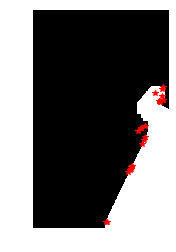

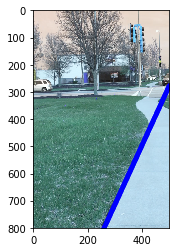

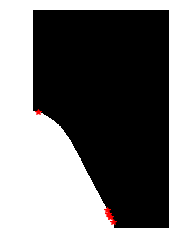

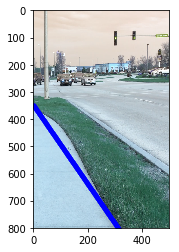

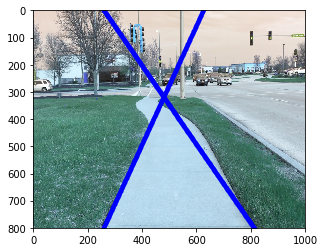

In [77]:
best_linear_boundary_detection_with_ROI(True, IMG_NAME="/Users/yxiao/Desktop/1.png", plot=False, plot_sift=True)

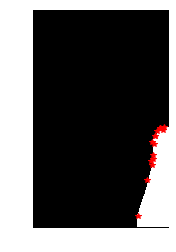

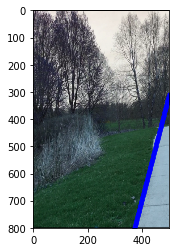

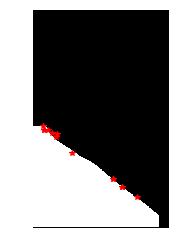

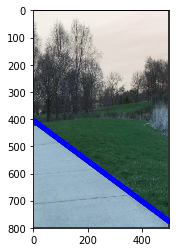

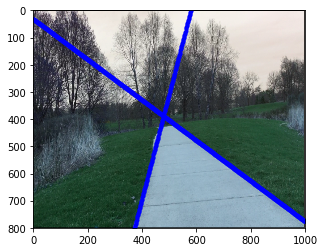

In [78]:
best_linear_boundary_detection_with_ROI(True, IMG_NAME="/Users/yxiao/Desktop/2.png", plot=False, plot_sift=True)

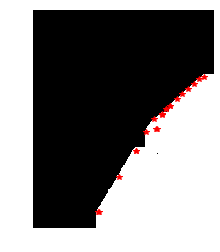

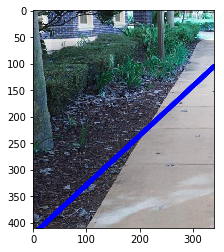

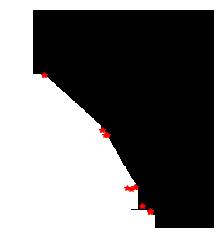

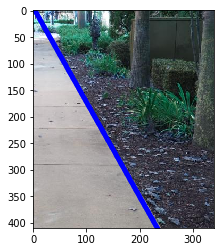

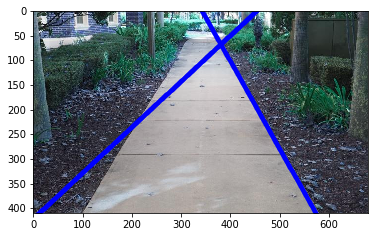

In [86]:
best_linear_boundary_detection_with_ROI(True, IMG_NAME="sidewalk/3.jpg", plot=False, plot_sift=True)

# </br>
# </br>
# </br>
# </br>
# </br>
# </br>
# ↓↓↓↓↓↓↓↓↓best_poly_boundary_detection_with_ROI ↓↓↓↓↓↓↓↓↓ 

In [ ]:
def best_poly_boundary_detection_with_ROI(isName, IMG_NAME="", s1plot=None, plot=False, plot_sift=False):
    if isName:
        s1plot = cv2.imread(IMG_NAME)
#         print("read_images")
    if s1plot.shape[0] > 800 or s1plot.shape[1] > 800:
        s1plot = cv2.resize(s1plot, (1000, 800))
    s1 = cv2.cvtColor(s1plot, cv2.COLOR_BGR2GRAY)
    s1 = ROI(s1)
    div =  int(s1.shape[1]/2)

    coef = 1.0
    coef_threshold = -0.3
    left = s1[:, :div]
    while coef >= coef_threshold:
        _, kpt, _ = ops(left, plot=plot, erode_size=3, dilate_size=3, plot_sift=plot_sift)
        ransacl = linear_model.RANSACRegressor(linear_model.LinearRegression(), residual_threshold = 10)
        ransacl = ransacl.fit(kpt[:, 0].reshape(-1, 1), kpt[:, 1].reshape(-1, 1))
    #     print(ransacl.estimator_.coef_, ransacl.estimator_.intercept_)
        coef = ransacl.estimator_.coef_[0,0]
#         print(coef)
        if coef >= coef_threshold:
            inliers_mask = ransacl.inlier_mask_.reshape(-1, 1)
            inliers_idx =  np.argwhere(inliers_mask==True)
            kpt = np.delete(kpt, inliers_idx, 0)
#             print(kpt.shape)
    if plot or plot_sift:
        x = np.linspace(0, left.shape[1], 1000).reshape(1, -1)
        plt.plot(x, x * ransacl.estimator_.coef_ + ransacl.estimator_.intercept_, 'b.')
        plt.imshow(s1plot[:, :div])
        plt.show()

    coef = -1.0
    coef_threshold = 0.3
    right = s1[:, div:]
    while coef <= coef_threshold:
        _, kpt, _ = ops(right, plot=plot, erode_size=3, dilate_size=3, plot_sift=plot_sift)
        ransacr = linear_model.RANSACRegressor(linear_model.LinearRegression())
        ransacr = ransacr.fit(kpt[:, 0].reshape(-1, 1), kpt[:, 1].reshape(-1, 1))
    #     print(ransacr.estimator_.coef_, ransacr.estimator_.intercept_)
        coef = ransacr.estimator_.coef_[0,0]
#         print(coef)
        if coef <= coef_threshold:
            inliers_mask = ransacr.inlier_mask_.reshape(-1, 1)
            inliers_idx =  np.argwhere(inliers_mask==True)
            kpt = np.delete(kpt, inliers_idx, 0)
#             print(kpt.shape)
    # plt.plot(kpt[:, 0].reshape(1, -1), kpt[:, 0] * ransac.estimator_.coef_ + ransac.estimator_.intercept_, 'b.')
    if plot or plot_sift:
        plt.plot(x, x * ransacr.estimator_.coef_ + ransacr.estimator_.intercept_, 'b.')
        plt.imshow(s1plot[:, div:])
        plt.show()

    x = np.linspace(0, s1plot.shape[1], 1000).reshape(1, -1)
#     print(ransacl.estimator_.coef_, ransacl.estimator_.intercept_)
#     print(ransacr.estimator_.coef_, ransacr.estimator_.intercept_)
    plt.plot(x, x * ransacl.estimator_.coef_ + ransacl.estimator_.intercept_, 'b.')
    plt.plot(x, (x-div) * ransacr.estimator_.coef_ + ransacr.estimator_.intercept_ , 'b.')
    plt.imshow(s1plot)
    plt.show()
    return s1plot

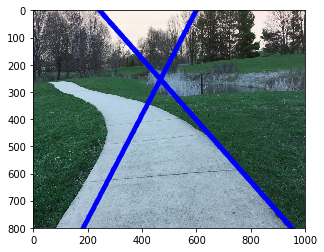

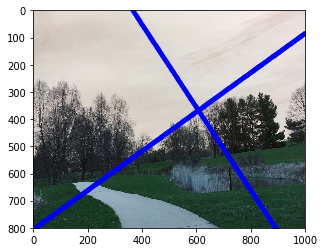

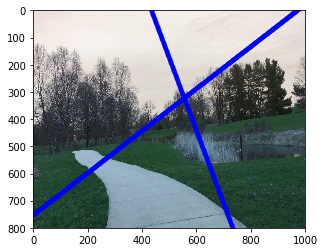

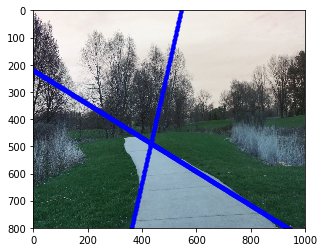

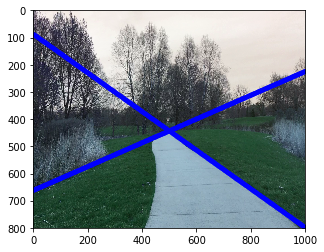

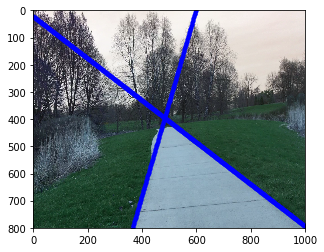

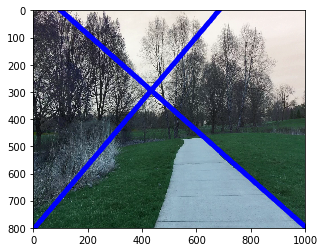

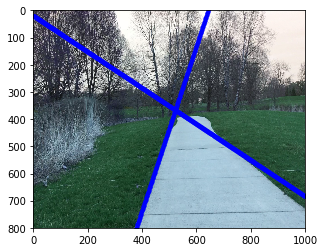

KeyboardInterrupt: 

In [93]:
cap = cv2.VideoCapture('/Users/yxiao/Desktop/Erlang/Erlang-System/dataset/3.MOV')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 20.0, (480, 320))
frames = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        frames += 1
#         print(frames)
        if frames % 60 == 1:
            plot = best_linear_boundary_detection_with_ROI(False, s1plot=frame, plot=False, plot_sift=False)
            out.write(plot)
#         cv2.imshow('Frame',frame)
#         if cv2.waitKey(25) & 0xFF == ord('q'):
#               break
    else: 
        break    
    #cv2.imshow('frame',color)
    #if cv2.waitKey(1) & 0xFF == ord('q'):
        #break
# print(frames)
out.release()
cap.release()
cv2.destroyAllWindows()

In [4]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged